# Plot temperature response over time

## Imports:

In [1]:
import xarray as xr
from IPython.display import clear_output
import numpy as np
import os
import re
from pathlib import Path
import pandas as pd
import tqdm
from scmdata import df_append, ScmDataFrame
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from ar6_ch6_rcmipfigs.constants import BASE_DIR
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, INPUT_DATA_DIR, RESULTS_DIR

#PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
#PATH_DT = OUTPUT_DATA_DIR / '/dT_data_rcmip_models.nc'
PATH_DT = OUTPUT_DATA_DIR / 'dT_data_RCMIP.nc'

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


## Set values:

In [3]:
first_y ='1850'
last_y = '2100'

**Set reference year for temperature change:**

In [4]:
ref_year = '2021'

In [5]:
FIGURE_DIR = RESULTS_DIR / 'figures/'

In [6]:
percentile='percentile'
climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [47]:
# variables to plot:
variables_erf_comp = [
    'ch4',
    'aerosol-radiation_interactions',
    'aerosol-cloud_interactions',
    'o3_tropospheric',
    #'F-Gases|HFC',
    'bc_on_snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['total_anthropogenic',
                     'total']
variables_all = variables_erf_comp + variables_erf_tot
# Scenarios to plot:
scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',  # 'ssp370-lowNTCF', Due to mistake here
                'ssp585']#, 'historical']

In [8]:

scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',  # 'ssp370-lowNTCF', Due to mistake here
                'ssp585', 'historical']

scenarios_fl_370 = ['ssp370', 'ssp370-lowNTCF-aerchemmip','ssp370-lowNTCF-gidden'# Due to mistake here
                ]


### Scenarios:

In [9]:
scenarios_fl=['ssp119',
              'ssp126',
              'ssp245',
              'ssp370',
              'ssp370-lowNTCF-aerchemmip',
              #'ssp370-lowNTCF-gidden',
              'ssp585']

In [10]:
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [11]:
ds_DT = xr.open_dataset(PATH_DT)

In [12]:
ds_DT#.climatemodel

<xarray.Dataset>
Dimensions:     (percentile: 3, scenario: 10, variable: 17, year: 251)
Coordinates:
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * variable    (variable) object 'co2' 'ch4' 'n2o' ... 'total_natural' 'total'
  * scenario    (scenario) object 'ssp534-over' ... 'ssp370-lowNTCF-gidden'
  * percentile  (percentile) object '5th percentile' 'median' '95th percentile'
Data variables:
    ERF         (scenario, variable, year) float64 ...
    time        (year) datetime64[ns] ...
    delta_t     (year) float64 ...
    Delta T     (percentile, scenario, variable, year) float64 ...

### Define stuff:

In [13]:
from ar6_ch6_rcmipfigs.utils.misc_func import new_varname
name_deltaT = 'Delta T'

In [14]:
variables_dt_comp = variables_erf_comp

## Compute sum of all SLCF forcers

### Concatinate SLCFs along new dimension:


s_y = first_y


def sum_name(var):
    """
    Returns the name off the sum o
    """
    return '|'.join(var.split('|')[0:2]) + '|' + 'All'



# make xarray with variable as new dimension:
_lst_f = []
_lst_dt = []
# Make list of dataArrays to be concatinated:
for var in variables_erf_comp:
    _lst_f.append(ds_DT[var])
    _lst_dt.append(ds_DT[new_varname(var, name_deltaT)])
# Name of new var:
erf_all = sum_name('Effective Radiative Forcing|Anthropogenic|all')
# Name of new var:
dt_all = sum_name(new_varname('Effective Radiative Forcing|Anthropogenic|all', name_deltaT))
ds_DT[erf_all] = xr.concat(_lst_f, pd.Index(variables_erf_comp, name='variable'))
ds_DT[dt_all] = xr.concat(_lst_dt, pd.Index(variables_erf_comp, name='variable'))
dt_totn = dt_all

In [15]:
dt_totn = ds_DT

## Plot $\Delta T$ from ref year:

In [42]:
from ar6_ch6_rcmipfigs.utils.plot import get_var_nicename

In [73]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic, get_ls_dic, trans_scen2plotlabel, get_scenario_c_dic, \
    get_scenario_ls_dic
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel

def get_fig_ax_tot(figsize=[13,12]):
    """
    Makes figure for total plot
    :param figsize:
    :return:
    """
    fig2 = plt.figure(constrained_layout=False, figsize=figsize)
    spec2 = gridspec.GridSpec(ncols=12, nrows=4, figure=fig2)
    com_axs = []
    for i in np.arange(2):
        for j in np.arange(3):
            if i==1 and j==2: continue
            com_axs.append(fig2.add_subplot(spec2[i, j*4:(j+1)*4]))
    all_ax = fig2.add_subplot(spec2[2:, 2:10])
    return fig2, com_axs, all_ax



def fix_ax(ax):
    #ls = pd.date_range('2010-1-1', periods=100, freq='Y')[0::10]
    #ax.set_xticks(list(ls))
    #ax.set_xlim(s_y2, e_y2)  # '2015','2100')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return

def fign_dt(var, s_y, s_y2):
    return '%s_refy%s_fy%s.png' % (var.replace(' ', '_').replace('|', '-'), s_y, s_y2)

ch4
aerosol-radiation_interactions
aerosol-cloud_interactions
o3_tropospheric
bc_on_snow


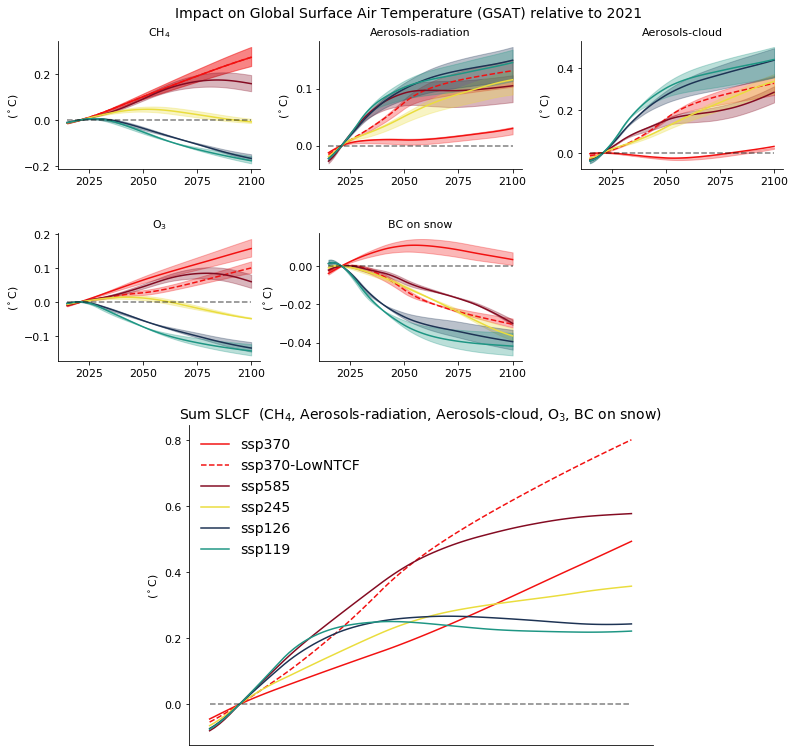

In [84]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel


#get_fig_ax_tot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders

figsize = [6, 4]
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()#get_ls_dic(ds_DT[climatemodel].values)


SMALL_SIZE = 11
MEDIUM_SIZE = 11
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig2, axs, ax_tot = get_fig_ax_tot()#fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
for var, ax in zip(variables_erf_comp, axs):

    print(var)

    #fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) 
        _da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn,year=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        #_da = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT[new_varname(var, name_deltaT)].sel(
        #    scenario=scn,
        #    time=slice(s_y,
        #               s_y)).squeeze()
        # Choose median: 
        _pl_da = _da.sel(percentile='median')
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn])
        #_pl_da.plot( c=cdic[scn], label=scn, linestyle = lsdic[scn])
        # compute standard deviation:
        #_std = _da.std(climatemodel)
        # plot +/- 1 standard deviation
        da_perc5 =  _da.sel(percentile=perc5)
        da_perc95 =  _da.sel(percentile=perc95)
        ax.fill_between(_pl_da['year'].values, 
                        da_perc5, 
                        da_perc95, 
                        alpha=0.3,
                        color=cdic[scn], 
                        label='_nolegen_'
                       )

    # various labels:
    ax.set_title('%s' % get_var_nicename(var))
    ax.set_ylabel('')
    ax.set_xlabel('')
    fix_ax(ax)
    # Plot zero line:
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
    

    
axs[0].set_ylabel('($^\circ$C)')
for ax in axs:
    #ax.set_ylabel('Change in temperature (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')
# Total:

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax = ax_tot

cdic = get_scenario_c_dic()
#for var in variables_erf_tot:  # , f_totn]:
for scn in list(set(scenarios_fl) - {'historical'}):
    # Plot dataset difference to first year, i.e.
    ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel( scenario=scn,
                   year=slice(s_y, s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel( scenario=scn, year=slice(s_y2, e_y2)) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile='median')
    # Sum up the variables:
    #print(_pl_da)
    #_pl_da = _pl_da.sel(variable=variables_erf_comp).sum(variable)
    # plot :
    _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), xticks=[], linestyle = lsdic[scn])
    # calculate standard deviation over the models:
    #_std = _da.sum(variable).std(climatemodel)
    # Fill between +/- 1 std
    #ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
    #                color=cdic[scn], label='_nolegend_')
    da_perc5 =  _da.sel(percentile=perc5)#.sel(variable=variables_erf_comp).sum(variable)
    da_perc95 =  _da.sel(percentile=perc95)#.sel(variable=variables_erf_comp).sum(variable)
    #ax.fill_between(_pl_da['year'].values, da_perc5, da_perc95, alpha=0.3,
    #                color=cdic[scn], label='_nolegen_')

_ds = ds_DT.sel(year=slice(s_y2, e_y2))
ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
plt.suptitle('Impact on Global Surface Air Temperature (GSAT) relative to 2021', fontsize=14)
# adjust plot visuals:
_str = ''
for var in ds_DT.sel(variable=variables_erf_comp)[variable].values: _str += f'{get_var_nicename(var)}, '
#ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])
ax.set_title('Sum SLCF  (%s)' % _str[:-2])
#ax.set_ylabel('$\Delta$ T ($^\circ$C)')
ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc=2)
fix_ax(ax)
plt.subplots_adjust(top=0.94, left=0.125, wspace=9.1, hspace=.5)
#plt.tight_layout()
#plt.savefig(FIGURE_DIR+ '/total_ref2021_from2015_all_2.png', dpi=300)
#plt.savefig(FIGURE_DIR+ '/total_ref2021_from2015_all_2.pdf')#, dpi=300)
plt.show()

ch4


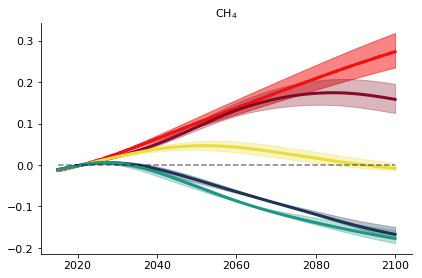

aerosol-radiation_interactions


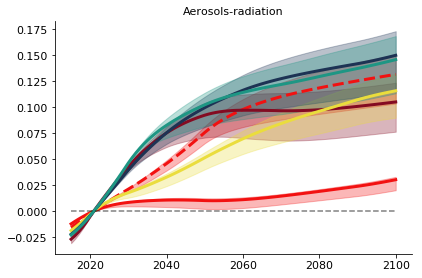

aerosol-cloud_interactions


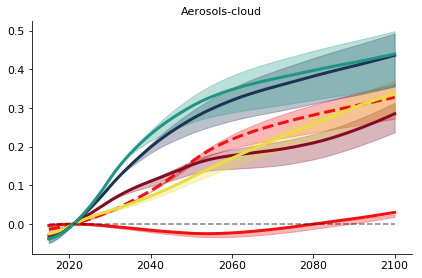

o3_tropospheric


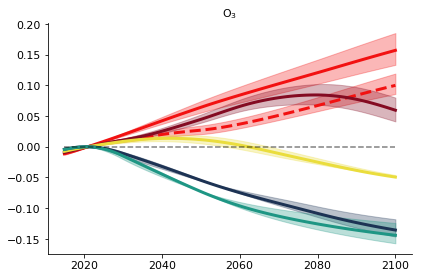

bc_on_snow


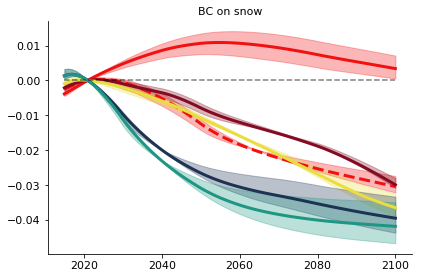

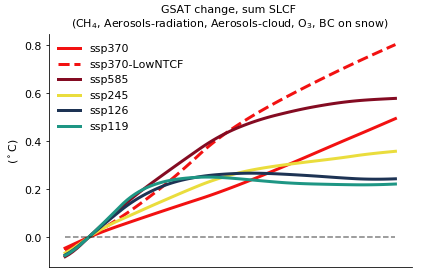

In [91]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel

figsize = [7, 4.5]

#get_fig_ax_tot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders

figsize = [6, 4]
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()#get_ls_dic(ds_DT[climatemodel].values)


SMALL_SIZE = 11
MEDIUM_SIZE = 11
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#fig2, axs, ax_tot = get_fig_ax_tot()#fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
for var in variables_erf_comp:#, axs):

    print(var)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) 
        _da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn,year=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        #_da = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT[new_varname(var, name_deltaT)].sel(
        #    scenario=scn,
        #    time=slice(s_y,
        #               s_y)).squeeze()
        # Choose median: 
        _pl_da = _da.sel(percentile='median')
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn], linewidth=3)
        #_pl_da.plot( c=cdic[scn], label=scn, linestyle = lsdic[scn])
        # compute standard deviation:
        #_std = _da.std(climatemodel)
        # plot +/- 1 standard deviation
        da_perc5 =  _da.sel(percentile=perc5)
        da_perc95 =  _da.sel(percentile=perc95)
        ax.fill_between(_pl_da['year'].values, 
                        da_perc5, 
                        da_perc95, 
                        alpha=0.3,
                        color=cdic[scn], 
                        label='_nolegen_'
                       )

    # various labels:
    ax.set_title('%s' % get_var_nicename(var))
    ax.set_ylabel('')
    ax.set_xlabel('')
    fix_ax(ax)
    # Plot zero line:
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
        # figname
    fign = FIGURE_DIR /fign_dt(var, s_y, s_y2)
    make_folders(str(fign))

    plt.tight_layout()
    plt.savefig(fign, dpi=300)
    plt.savefig(fign.with_suffix('.pdf'))#fign[:-3]+'pdf')#, dpi=200)
    plt.show()

    
    
axs[0].set_ylabel('($^\circ$C)')
for ax in axs:
    #ax.set_ylabel('Change in temperature (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')


fig, ax = plt.subplots(1, 1, figsize=figsize)  # [9,5])

cdic = get_scenario_c_dic()
#for var in variables_erf_tot:  # , f_totn]:
for scn in list(set(scenarios_fl) - {'historical'}):
    # Plot dataset difference to first year, i.e.
    ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel( scenario=scn,
                   year=slice(s_y, s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel( scenario=scn, year=slice(s_y2, e_y2)) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile='median')
    # Sum up the variables:
    #print(_pl_da)
    #_pl_da = _pl_da.sel(variable=variables_erf_comp).sum(variable)
    # plot :
    _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), xticks=[], linestyle = lsdic[scn], linewidth=3)
    # calculate standard deviation over the models:
    #_std = _da.sum(variable).std(climatemodel)
    # Fill between +/- 1 std
    #ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
    #                color=cdic[scn], label='_nolegend_')
    da_perc5 =  _da.sel(percentile=perc5)#.sel(variable=variables_erf_comp).sum(variable)
    da_perc95 =  _da.sel(percentile=perc95)#.sel(variable=variables_erf_comp).sum(variable)
    #ax.fill_between(_pl_da['year'].values, da_perc5, da_perc95, alpha=0.3,
    #                color=cdic[scn], label='_nolegen_')
    

    
# adjust plot visuals:
_str = ''
for var in ds_DT.sel(variable=variables_erf_comp)[variable].values: _str += f'{get_var_nicename(var)}, '
ax.set_title('GSAT change, sum SLCF \n(%s)' % _str[:-2])

ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc=2)
fix_ax(ax)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')


plt.tight_layout()
fn = FIGURE_DIR / fign_dt('total', s_y,s_y2 )
plt.savefig(fn, dpi=200)
plt.savefig(fn.with_suffix('.pdf'))#, dpi=200)
plt.show()
    

# Supplementary plots:

## Plot $\Delta$ T and ERF with reference year +/- 1 standard deviation of the models

In [98]:
_pl_da

<xarray.DataArray 'Delta T' (year: 251)>
array([0.002508, 0.004796, 0.006903, ..., 0.147716, 0.146023, 0.144364])
Coordinates:
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
    variable    <U3 'ch4'
    scenario    <U6 'ssp119'
    percentile  <U6 'median'

In [101]:
_da#.sel(percentile='median')

<xarray.DataArray 'Delta T' (percentile: 3, year: 251)>
array([[0.003416, 0.006329, 0.008838, ..., 0.122089, 0.120785, 0.119512],
       [0.002508, 0.004796, 0.006903, ..., 0.147716, 0.146023, 0.144364],
       [0.002357, 0.004546, 0.006598, ..., 0.184119, 0.182122, 0.180164]])
Coordinates:
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
    variable    <U3 'ch4'
    scenario    <U6 'ssp119'
  * percentile  (percentile) object '5th percentile' 'median' '95th percentile'

In [99]:
name_deltaT

'Delta T'

ch4


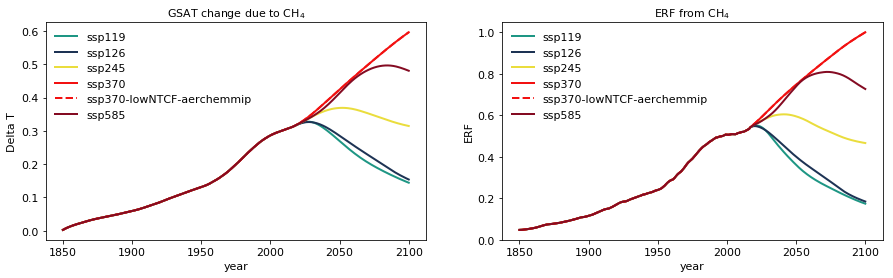

aerosol-radiation_interactions


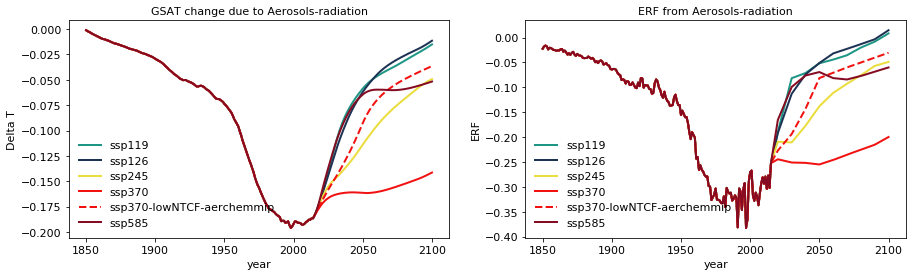

aerosol-cloud_interactions


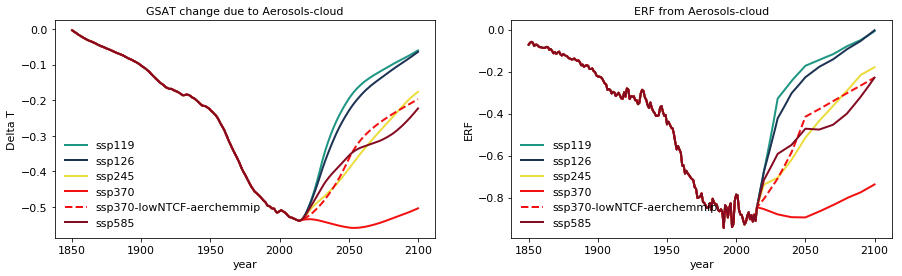

o3_tropospheric


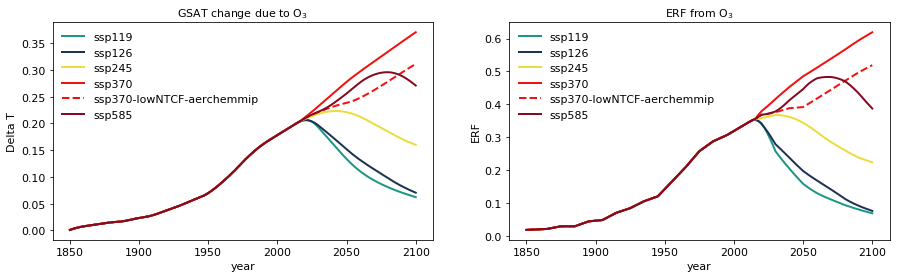

bc_on_snow


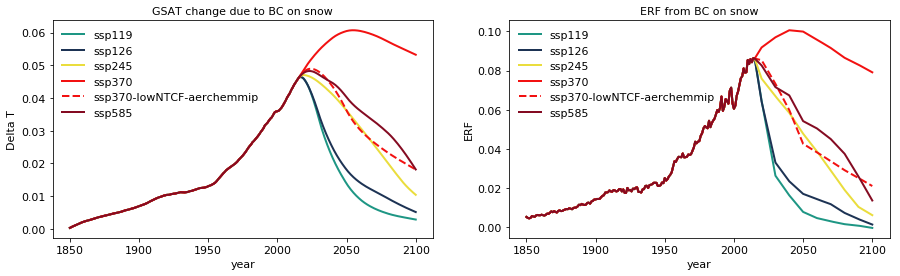

In [110]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_ls_dic, get_scenario_c_dic

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()#get_ls_dic(ds_DT[climatemodel].values)
s_y = '2021'
e_y = '2100'
# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:#) - {'historical'}):
        first = True
        #_da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) 
        #_da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn,year=slice(s_y, s_y)).squeeze()
        #_da = _da_ally - _da_refy

        _da1 = ds_DT[name_deltaT].sel(variable = var, scenario=scn).sel(percentile='median')        
        _da2 = ds_DT['ERF'].sel(variable = var, scenario=scn)
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da#.sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn], linewidth = 2)
            #_std = _da.std(climatemodel)
            # fill between +/z 1 std
            #ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=alpha,
            #                color=cdic[scn], label='_nolegen_')
    print(var)

    axs[0].set_title('GSAT change due to %s' %get_var_nicename(var))
    axs[1].set_title('ERF from %s'%get_var_nicename(var))
    # axs[1].set_title('%s'%( ('|'.join(var.split('|')[1:]))))

    axs[0].legend(frameon=False)#, loc=2)
    axs[1].legend(frameon=False)#, loc=2)

    plt.show()

Subtracting year 2021, while still plotting from 2015. Thus the results represent the cooling/warming with respect to year 2021

ch4


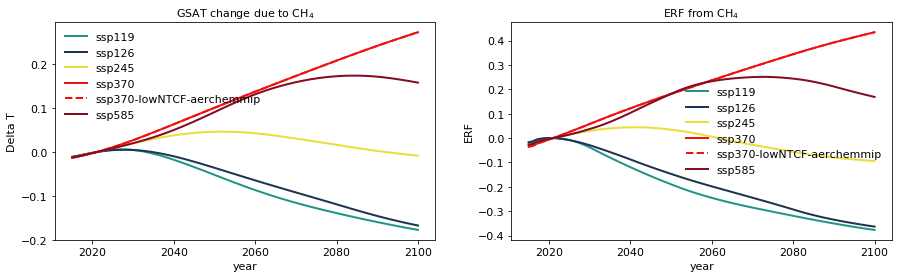

aerosol-radiation_interactions


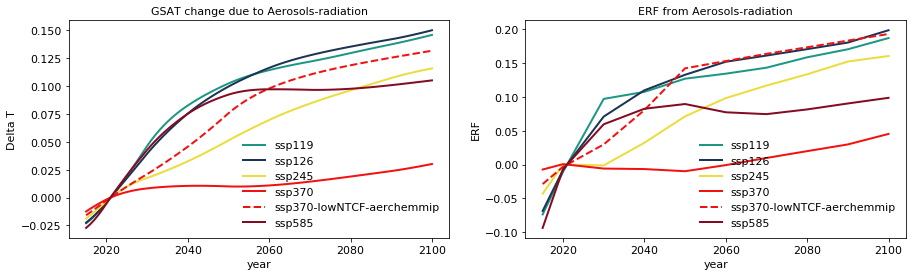

aerosol-cloud_interactions


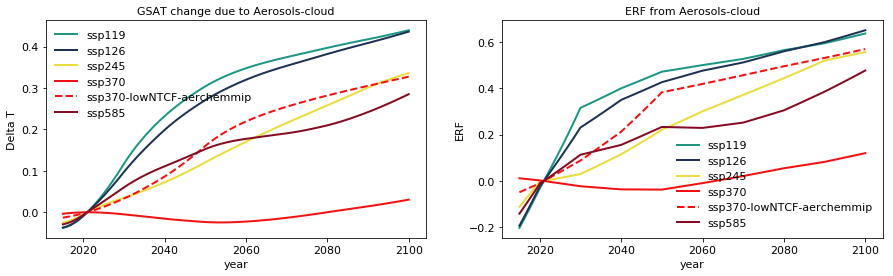

o3_tropospheric


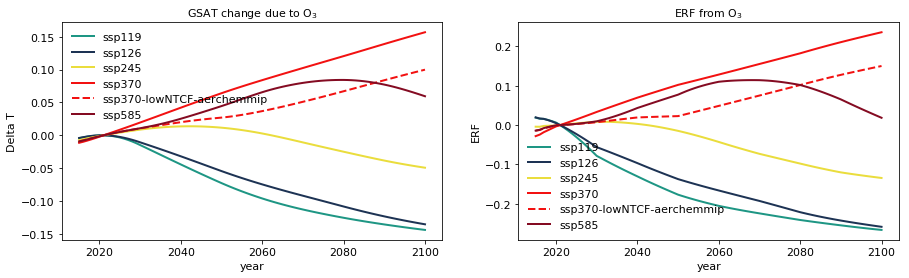

bc_on_snow


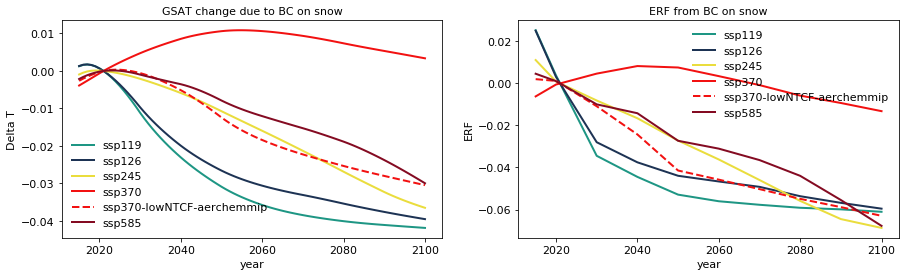

In [117]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_ls_dic, get_scenario_c_dic

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()#get_ls_dic(ds_DT[climatemodel].values)
s_y = '2021'
e_y = '2100'
s_y2 = '2015'
e_y2 = '2100'

# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:#) - {'historical'}):
        first = True
        #_da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) 
        #_da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn,year=slice(s_y, s_y)).squeeze()
        #_da = _da_ally - _da_refy
        _da1 = ds_DT[name_deltaT].sel(variable=var, scenario=scn,year=slice(s_y2, e_y2)) - ds_DT[name_deltaT].sel(variable=var,scenario=scn, 
                                                                                                                  year=slice(s_y, s_y)).squeeze()
        _da1 = _da1.sel(percentile='median')
        _da2 = ds_DT['ERF'].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) - ds_DT['ERF'].sel(variable=var, 
                                                                                                   scenario=scn,
                                                                                                   year=slice(s_y, s_y)).squeeze()

        #_da1 = ds_DT[name_deltaT].sel(variable = var, scenario=scn).sel(percentile='median')        
        #_da2 = ds_DT['ERF'].sel(variable = var, scenario=scn)
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da#.sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn], linewidth = 2)
            #_std = _da.std(climatemodel)
            # fill between +/z 1 std
            #ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=alpha,
            #                color=cdic[scn], label='_nolegen_')
    print(var)

    axs[0].set_title('GSAT change due to %s' %get_var_nicename(var))
    axs[1].set_title('ERF from %s'%get_var_nicename(var))
    # axs[1].set_title('%s'%( ('|'.join(var.split('|')[1:]))))

    axs[0].legend(frameon=False)#, loc=2)
    axs[1].legend(frameon=False)#, loc=2)

    plt.show()